<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_logical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


##Download Dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


(-0.5, 499.5, 332.5, -0.5)

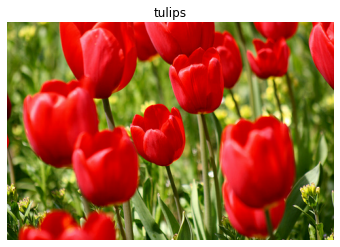

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
plt.imshow(image.numpy().astype('uint8'))
plt.title(get_label_name(label))
plt.axis('off')

###Resizing and Rescaling

In [5]:
from tensorflow.keras.models import Sequential

IMG_SIZE = 180
resizing_and_rescaling = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])


(-0.5, 179.5, 179.5, -0.5)

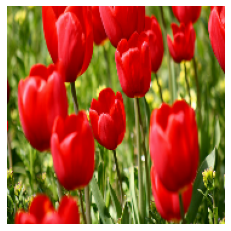

In [6]:
result = resizing_and_rescaling(image)
plt.imshow(result)
plt.axis('off')

In [7]:
print("Min: {} and Max: {} values of result.".format(result.numpy().min(), result.numpy().max()))

Min: 0.0 and Max: 1.0 values of result.


##Data Augmentation

In [8]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [9]:
print(image.shape)
print(result.shape)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

(333, 500, 3)
(180, 180, 3)


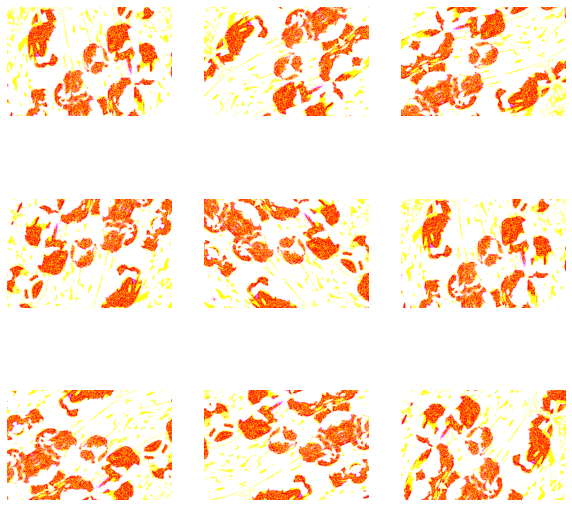

In [10]:

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.show()

##Apply preprocessing layers to Dataset

In [11]:
batch_size = 32

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds, shuffle=False, augment=False):
    """Apply keras preprocess layers to dataset."""
    ds = ds.map(lambda x, y: (resizing_and_rescaling(x), y), 
                num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(10000)
    # Batch all datasets
    ds = ds.batch(batch_size)
    # Use augmentation only on training data
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    # Use buffered prefetch on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train_ds = preprocess(train_ds, shuffle=True, augment=True)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

In [13]:
print("Number of train examples after augmentation:",len(train_ds))
print("Validation dataset length after augmentation:", len(val_ds))
print("Test dataset length after augmentaiton:", len(test_ds))

Number of train examples after augmentation: 92
Validation dataset length after augmentation: 12
Test dataset length after augmentaiton: 12


##Create a model

In [14]:
model = Sequential([
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [15]:
# Train for a few epochs
epochs = 5 

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 129s 1s/step - loss: 1.3347 - accuracy: 0.4230 - val_loss: 1.0798 - val_accuracy: 0.6131
Epoch 2/5
92/92 [==============================] - 127s 1s/step - loss: 1.0581 - accuracy: 0.5817 - val_loss: 0.9826 - val_accuracy: 0.6240
Epoch 3/5
92/92 [==============================] - 136s 1s/step - loss: 0.9584 - accuracy: 0.6175 - val_loss: 0.9105 - val_accuracy: 0.6485
Epoch 4/5
92/92 [==============================] - 109s 1s/step - loss: 0.8968 - accuracy: 0.6454 - val_loss: 0.8875 - val_accuracy: 0.6485
Epoch 5/5
92/92 [==============================] - 91s 955ms/step - loss: 0.8489 - accuracy: 0.6604 - val_loss: 0.8646 - val_accuracy: 0.6676


In [16]:
loss, acc = model.evaluate(test_ds)
print("Accuracy: {:.2f}%, Loss: {:.2f}".format(acc *100, loss))

12/12 [==============================] - 4s 280ms/step - loss: 0.8280 - accuracy: 0.6839
Accuracy: 68.39%, Loss: 0.83


##Custom Data Augment

In [17]:
def random_invert_img(x, f=0.5):
    if tf.random.uniform([]) < f:
        return 255 - x
    else:
        return x

In [18]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

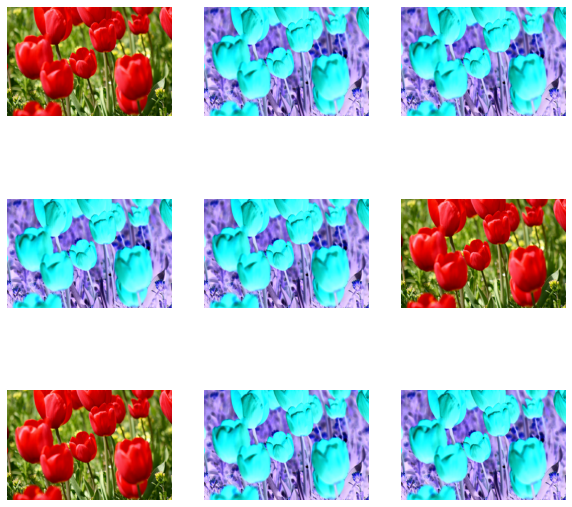

In [19]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [20]:
# Subclassing
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super(RandomInvert, self).__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

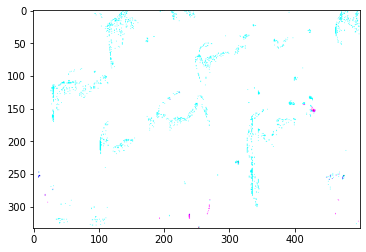

In [21]:
plt.imshow(RandomInvert()(image)[0])

##ِData Augmentation using tf.image

In [22]:
# reimport dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


(-0.5, 499.5, 332.5, -0.5)

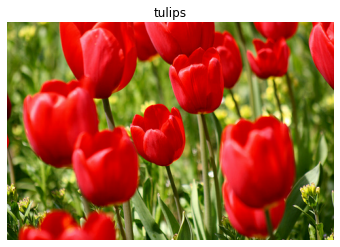

In [23]:
image, label = next(iter(train_ds))

plt.imshow(image)
plt.title(get_label_name(label))
plt.axis('off')

In [24]:
def visualize(original, augmented):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)
    plt.title("Augmented")
    plt.axis('off')

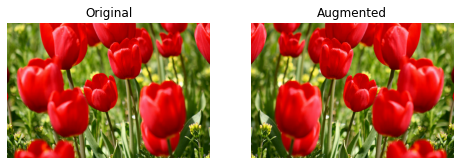

In [25]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

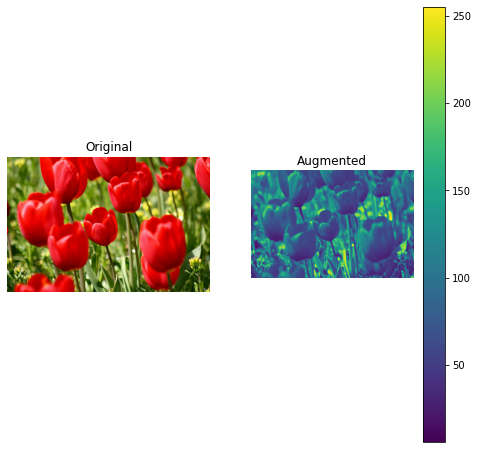

In [26]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

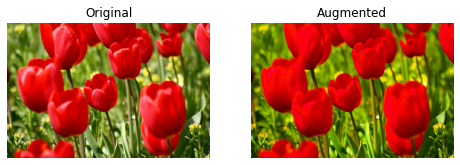

In [27]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

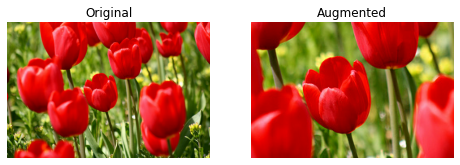

In [28]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

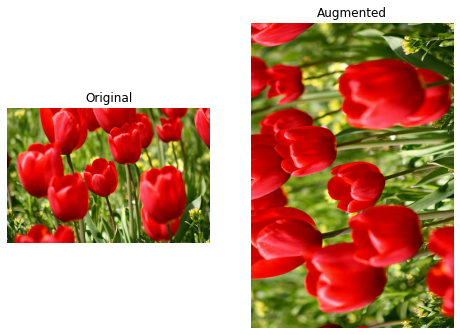

In [29]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

##Random Transformations

(0, 0)
(1, 0)
(2, 0)


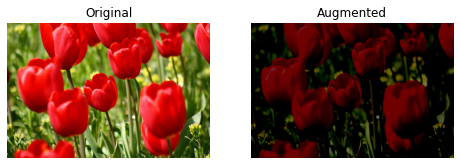

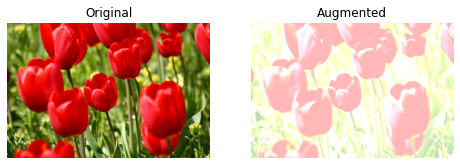

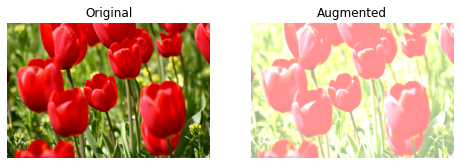

In [30]:
# Random brightness
for i in range(3):
    seed = (i, 0)
    print(seed)
    brightened = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=seed)
    visualize(image, brightened)

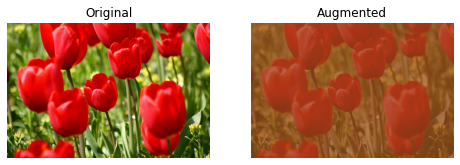

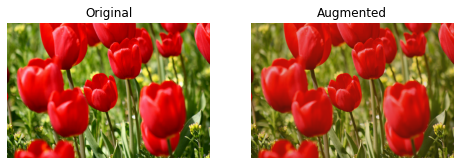

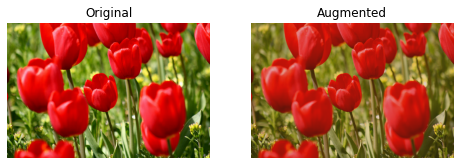

In [31]:
# Random contrast
for i in range(3):
    seed = (i, 0)
    contrast = tf.image.stateless_random_contrast(image, lower=0.1, upper=0.9, seed=seed)
    visualize(image, contrast)

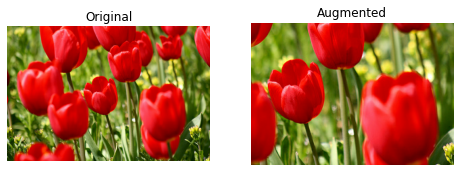

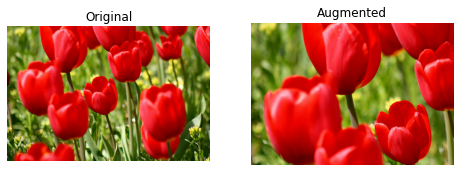

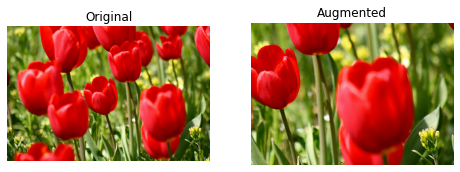

In [32]:
# Random crop
for i in range(3):
    seed = (i, 0)
    cropped = tf.image.stateless_random_crop(image, size=[210, 300, 3], seed=seed)
    visualize(image, cropped)

In [41]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

print("Train dataset length:", len(train_ds))
print("Validation dataset length:", len(val_ds))
print("Test dataset length:", len(test_ds))

Train dataset length: 2936
Validation dataset length: 367
Test dataset length: 367


In [42]:
def resize_and_rescale(image, label):
    """Resize the image into target width and height, then normalize it."""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.)
    return image, label

In [43]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+6, IMG_SIZE+6)
    # Make new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed
    )
    image = tf.clip_by_value(image, 0, 1)
    return image, label
    

In [45]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [46]:
train_ds = (
    train_ds.shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)

val_ds = (
    val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)

test_ds = (
    test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)

In [47]:
# Create a random number generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [50]:
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [52]:
train_ds = (
    train_datasets.shuffle(1000).map(f, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)

val_ds = (
    val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)

test_ds = (
    test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)